In [2]:
import numpy as np
def source_function( x, y ):
    if ( x >= 0.1 and x <= 0.3 and y >= 0.1 and y <= 0.3 ):
        return 1.0
    else:
        return 0.0

np_source_function = np.vectorize(source_function)

In [3]:
# Finds the index k = 0,1,2,...,N-1 in the vector corresponding to the grid
# point (x_i, y_j) where i,j = 0,1,2,...,n-1

def indexFD(i, j, n):
  k = ( i*n + j )
  return k

def reverseIndexFD(k, n):
    i = k // n
    j = k % n
    return i, j

In [4]:
import numpy as np

def boundaryConditions(n):

  extNodes = []

  # Find nodes at the boundary of the square
  for j in range(0,n):
    extNodes.append( indexFD(j,0,n) )
    extNodes.append( indexFD(j,n-1,n) )
    extNodes.append( indexFD(0,j,n) )
    extNodes.append( indexFD(n-1,j,n) )

  extNodes = np.unique(extNodes)
  intNodes = np.setdiff1d(np.arange(0,n**2), extNodes);

  return intNodes, extNodes

In [5]:
import scipy as sp
import numpy as np

def diffusionMatrix( mux, muy, h ):
  n = int(1./h + 1)
  N = n**2
  A = sp.sparse.lil_array((N, N), dtype=np.float64)

  # Pass through all grid points and apply local stencil

  stencil = np.array([(mux+muy)*2., -mux*1., -mux*1., -muy*1., -muy*1.]) / h**2

  # Loop over each internal node in the grid, i,j = 1,2,...,n-2
  for i in range(1,n-1):
    for j in range(1,n-1):
      # Find k-indices of the four neighbouring nodes
      localStencilIndices = np.array([indexFD(i,j,n), indexFD(i+1,j,n), indexFD(i-1,j,n), indexFD(i,j+1,n), indexFD(i,j-1,n)])

      # Add the local stencil for node (x_i,y_j) to the matrix
      currentRow = indexFD(i,j,n)
      for m in range (0,5):
        A[currentRow, localStencilIndices[m]] = A[currentRow, localStencilIndices[m]] + stencil[m]

  # After the matrix A has been assembled, we convert it to the column-major format
  # for more efficient computations
  A = A.tocsc()

  return (A)

In [6]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse.linalg import norm

def diffusionGradSolver( mux, muy, h, tol, maxiter, M ):
  n = int(1./h + 1)  # dimension of spatial mesh in each dimension
  N = n**2
  f = sp.sparse.csc_array((N, 1), dtype=np.float64)

  F = np.zeros((N, 1), dtype=np.float64)
  intNodes, extNodes = boundaryConditions(n)
  
  # Placeholder for an initial guess
  u0 = np.zeros((N, 1))

  # Evaluate the source function
  for k in range (0,N):
    i, j = reverseIndexFD(k, n)
    F[k] = source_function( i*h, j*h )
  
  # Assemble the diffusion matrix
  A = diffusionMatrix(mux, muy, h)
  A_int = A[intNodes][:, intNodes]
  F_int = F[intNodes]
  u0_int = u0[intNodes]

  # We plot the sparsity pattern of the matrix A to check that it has been
  # correctly assembled.
  # fig = plt.figure()
  # ax = fig.add_subplot(111)
  # cax = ax.matshow(A.toarray(), vmin=-4./h*mux, vmax=4./h*mux, cmap='coolwarm')
  # plt.title("Sparsity pattern")
  # fig.colorbar(cax)
  # plt.show()


  def iterate_count(x):
    iterate_count.iterate_counts += 1

  iterate_count.iterate_counts = 0

  f[intNodes], info = sp.sparse.linalg.cg(A_int, F_int, x0=None, tol=tol, maxiter=maxiter, M=M, callback=iterate_count, atol=None)
  print(f'Exit code: {info}')
  print(f'Number of iterations: {iterate_count.iterate_counts}')

  f[extNodes] = u0[extNodes]
  
  return f.toarray()


In [7]:
h = 0.02
mux = 1
muy = 1
solgrad = diffusionGradSolver(mux, muy, h, 1e-6, 1000, None)

Exit code: 0
Number of iterations: 133


/usr/lib/python3/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


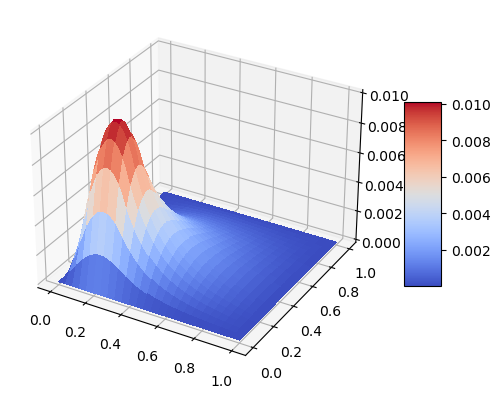

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = solgrad.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.0, 0.01)


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

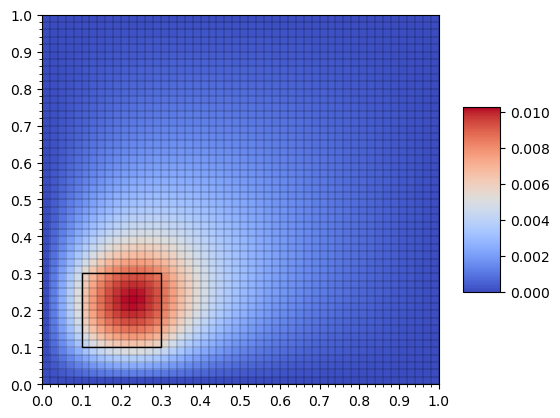

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, ax = plt.subplots()

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = solgrad.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf = ax.pcolor(X, Y, Z[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch
rect = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
hx = 0.1
# Add a grid
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
plt.minorticks_on()
plt.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
major_ticks = np.arange(0., 1.+hx, hx)
minor_ticks = np.arange(0., 1.+hx, hx/5)

plt.xticks(major_ticks)
plt.yticks(major_ticks)
plt.show()

(d) myPCG Implementation

In [10]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt


def myPCG( A, b, L, U, tol, maxit ):
    #A is the matrix produced by diffusionMatrix
    #b is the RHS calculated by the source function
    #L and U are the factors of the preconditioner from spilu
    #tol is the tolerance for the residual
    # maxit is the maximum number of iterations

    # Initialize parameters
    M = (L @ U)
    x = np.zeros_like(b)  # Initial guess
    r0 = b - (A@x)  # Initial residual
    z0 = sp.sparse.linalg.spsolve(M,r0)  # Apply preconditioner
    d0 = z0.copy()
    i=0
    while np.linalg.norm(r0,2) > tol and i < maxit:
        alpha = (r0@z0) / (d0.T@A@d0)
        x += alpha * d0
        r1 = r0 - alpha * (A@d0)
        z1 = sp.sparse.linalg.spsolve(M,r1)

        # Check for convergence
        if np.linalg.norm(r1,2) < tol and i > 0:
            print(f"Number of iterations = {i}, Norm = {np.linalg.norm(r1,2)}")
            return x

        beta = (r1 @ z1) / (r0 @ z0)
        d0 = z1 + beta * d0
        r0, z0 = r1, z1
        i += 1
    
    print(f'Number of iterations = {i}, Norm = {np.linalg.norm(r1,2)}')
    return x

In [11]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import norm
import matplotlib.pyplot as plt

def myPCGSolver(mux, muy, h, tol, maxit, drop_tol):
    n = int(1./h + 1)
    N = n**2
    intNodes, extNodes = boundaryConditions(n)

    # Generate diffusion matrix
    A = diffusionMatrix(mux, muy, h)
    A_int = A[intNodes][:, intNodes]
    
    # Create ILU preconditioner using scipy
    M = sp.sparse.linalg.spilu(A_int, drop_tol=drop_tol)
    L = M.L
    U = M.U

    print("Number of nonzero elements in L:", L.nnz)
    print("Number of nonzero elements in U:", U.nnz)
    
    # Define source term and initialize vectors
    b = np.zeros(N, dtype=np.float64)
    for k in range (0,N):
        i, j = reverseIndexFD(k, n)
        b[k] = source_function( i*h, j*h )
    b_int = b[intNodes]

    sol = np.zeros_like(b)
    sol[intNodes] = myPCG(A_int,b_int,L,U,tol,maxit)
    return sol


In [28]:
import time

h = 0.02
mux = 1.0
muy = 1.0
tol = 1e-6
maxit = 1000
drop_tol = 0.1

solcg = diffusionGradSolver(mux, muy, h, tol, maxit, None)
solpcg = myPCGSolver(mux,muy,h,tol,maxit,drop_tol)

abs_diff = np.abs(solcg - solpcg)
print(np.sum(abs_diff))


/usr/lib/python3/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Exit code: 0
Number of iterations: 133
Number of nonzero elements in L: 15985
Number of nonzero elements in U: 9692
Number of iterations = 1000, Norm = 0.13954732300425035
12834.682256632608


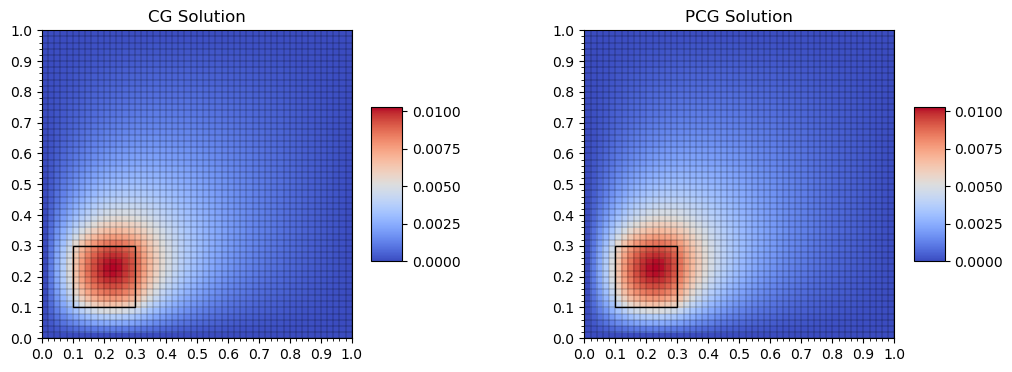

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.patches as patches

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # Increase the figure size to make the plot area wider
ax1 = axs[0]
ax2 = axs[1]

fig.subplots_adjust(wspace=0.4)  # Increase the padding between subplots

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z1 = solcg.reshape(int(1./h+1),int(1./h+1))
Z2 = solpcg.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf1 = ax1.pcolor(X, Y, Z1[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf2 = ax2.pcolor(X, Y, Z2[:-1,:-1], shading='flat', cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Create a Rectangle patch for ax1
rect1 = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Create a Rectangle patch for ax2
rect2 = patches.Rectangle((0.1, 0.1), 0.2, 0.2, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
ax1.add_patch(rect1)
ax2.add_patch(rect2)

# Add a grid to ax1
ax1.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.minorticks_on()
ax1.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.set_xticks(np.arange(0., 1.+hx, hx))
ax1.set_yticks(np.arange(0., 1.+hx, hx))

# Add a color bar which maps values to colors.
cbar1 = fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
cbar2 = fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

hx = 0.1
# Add a grid
ax1.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.minorticks_on()
ax1.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
ax1.set_xticks(np.arange(0., 1.+hx, hx))
ax1.set_yticks(np.arange(0., 1.+hx, hx))
ax1.set_title('CG Solution')

ax2.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.2)
ax2.minorticks_on()
ax2.grid(which='minor', axis='both', linestyle='-', color='k', linewidth=0.2)
ax2.set_xticks(np.arange(0., 1.+hx, hx))
ax2.set_yticks(np.arange(0., 1.+hx, hx))
ax2.set_title('PCG Solution')

plt.show()

In [14]:
# #Timer
# import time

# h = 0.1
# mux = 1
# muy = 1
# tol = 1e-6
# maxit = 10000
# drop_tol = 0.1

# i=0
# tstart = time.thread_time()
# for i in range(0,1000):
#     solcg = diffusionGradSolver(mux, muy, h, drop_tol, maxit, None)
# tend = time.thread_time()

# j=0
# tstart1 = time.thread_time()
# for j in range(0,1000):
#     solpcg = myPCGSolver(mux,muy,h,tol,maxit,drop_tol)
# tend1 = time.thread_time()

# print('Mean time spent for one linear solve using CG = ' + str((tend-tstart) * 10.) + ' milliseconds')
# print('Mean time spent for one linear solve using PCG = ' + str((tend1-tstart1) * 10.) + ' milliseconds')

In [44]:
#Check A
h = 0.5
mux=1.0
muy=1.0
drop_tol = 0.1

A = diffusionMatrix(mux, muy, h)
intNodes, extNodes = boundaryConditions(int(1./h+1))
A_int = A[intNodes][:, intNodes]
M = sp.sparse.linalg.spilu(A_int, drop_tol=drop_tol)
L = M.L
U = M.U
A.todense()



A[4, 1] = -4.0
A[4, 3] = -4.0
A[4, 4] = 16.0
A[4, 5] = -4.0
A[4, 7] = -4.0
U[0, 0] = 16.0
L[0, 0] = 1.0
